In [52]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_roc_curve, plot_precision_recall_curve
from sklearn.decomposition import PCA

import pandas as pd

from typing import Tuple, Union

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [21]:
RANDOM_STATE = 42

# Data Preprocessing


In [68]:
def load_data(path:str, random_state=42, valid_size=0.2, mode="train") -> Union[Tuple[Tuple[pd.DataFrame, pd.DataFrame],
                                                                          Tuple[pd.DataFrame, pd.DataFrame] ],
                                                                          Tuple[pd.DataFrame, pd.DataFrame]]:
    replace_categories = {2: 1,1: 0}
    train = pd.read_csv(f'{path}/ExoTrain.csv')  # TODO read by wildcard
    test = pd.read_csv(f'{path}/ExoTest.csv')

    # TODO unit test idea, check values beforehand to replace
    train["LABEL"] = train["LABEL"].replace(replace_categories)
    test["LABEL"] = test["LABEL"].replace(replace_categories)

    X_train = train.drop("LABEL", axis=1)
    y_train = train.loc[:, "LABEL"]

    X_test = train.drop("LABEL", axis=1)
    y_test = train.loc[:, "LABEL"]

    if mode == "train":
        return X_train, y_train
    elif mode == "test":
        return X_test, y_test


In [62]:
train_data = load_data("data/", mode="train")

In [73]:
X, y = train_data

In [74]:
pca = PCA(n_components=24, random_state=RANDOM_STATE)
X = pca.fit_transform(X)

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)


In [76]:
y_train.value_counts()

0    4040
1      29
Name: LABEL, dtype: int64

In [77]:
over_sample = SMOTE(random_state=RANDOM_STATE)

X_oversampled, y_oversampled = over_sample.fit_resample(X, y)

In [78]:
X_train_oversampled, X_valid_oversampled,y_train_oversampled, y_valid_oversampled = train_test_split(X_oversampled,
                                                                                                     y_oversampled, test_size=0.2,
                                                                                                     random_state=RANDOM_STATE)

In [79]:
y_train_oversampled.value_counts()

1    4073
0    4007
Name: LABEL, dtype: int64

In [81]:
y_valid_oversampled.value_counts()

0    1043
1     977
Name: LABEL, dtype: int64

# Modeling

## Experiments with unscaled data

In [93]:
gbdt_unscaled = GradientBoostingClassifier(random_state=RANDOM_STATE)  # we will train this on original data
gbdt_unscaled_smote = GradientBoostingClassifier(random_state=RANDOM_STATE)

rf_unscaled = RandomForestClassifier(random_state=RANDOM_STATE)
rf_unscaled_smote = RandomForestClassifier(random_state=RANDOM_STATE)

In [94]:
gbdt_unscaled.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [95]:
gbdt_unscaled_smote.fit(X_train_oversampled, y_train_oversampled)

GradientBoostingClassifier(random_state=42)

In [96]:
rf_unscaled.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [104]:
rf_unscaled_smote.fit(X_train_oversampled, y_train_oversampled)

RandomForestClassifier(random_state=42)

In [97]:
def model_evaluation(model, X_test, y_test):
    print(model.__class__.__name__)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_roc_curve(model, X_test, y_test)
    plot_precision_recall_curve(model, X_test, y_test)
    plot_roc_curve(model, X_test, y_test)
    print("*"*50)

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1010
           1       0.00      0.00      0.00         8

    accuracy                           0.99      1018
   macro avg       0.50      0.50      0.50      1018
weighted avg       0.98      0.99      0.99      1018

**************************************************


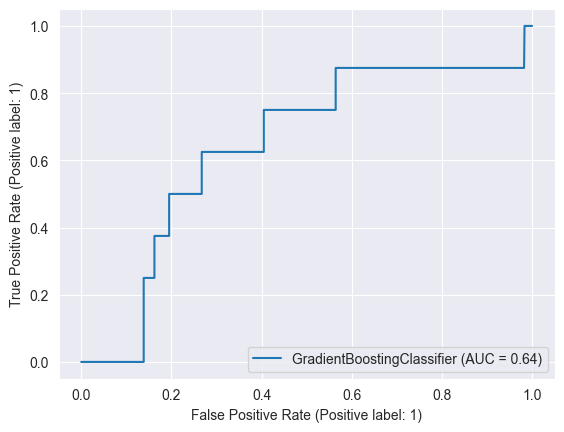

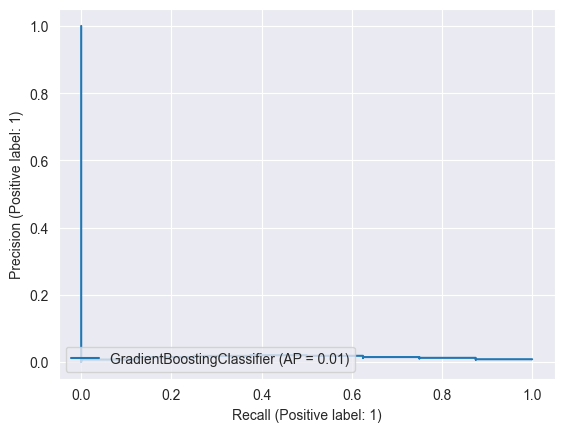

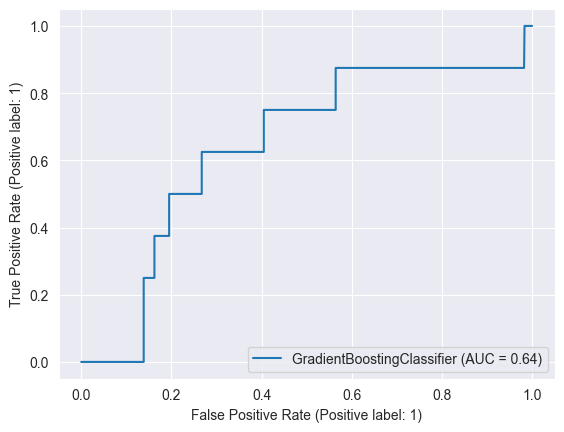

In [98]:
model_evaluation(gbdt_unscaled, X_valid, y_valid)

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1043
           1       0.95      0.99      0.97       977

    accuracy                           0.97      2020
   macro avg       0.97      0.97      0.97      2020
weighted avg       0.97      0.97      0.97      2020

**************************************************


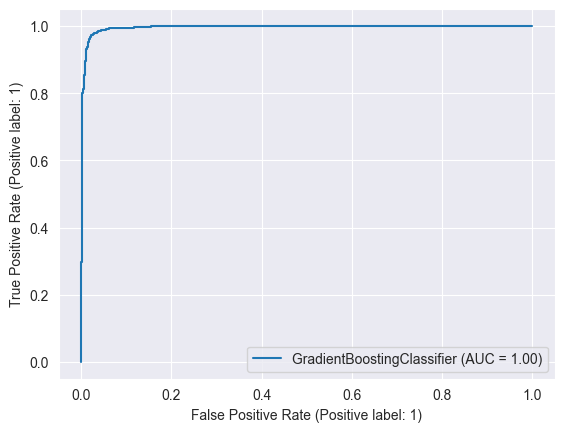

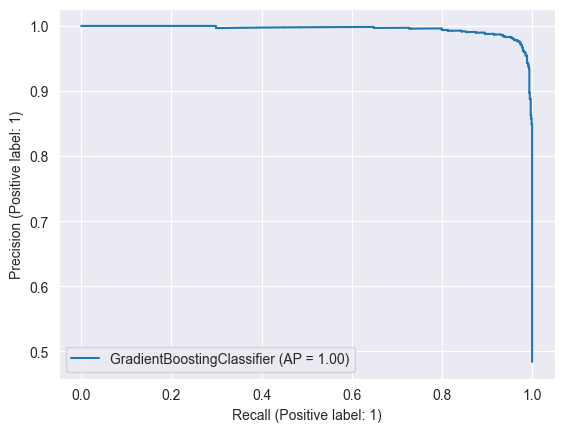

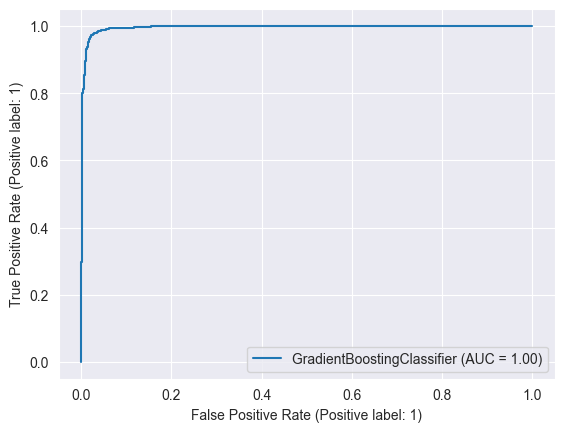

In [99]:
model_evaluation(gbdt_unscaled_smote, X_valid_oversampled, y_valid_oversampled)

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1010
           1       0.00      0.00      0.00         8

    accuracy                           0.99      1018
   macro avg       0.50      0.50      0.50      1018
weighted avg       0.98      0.99      0.99      1018

**************************************************


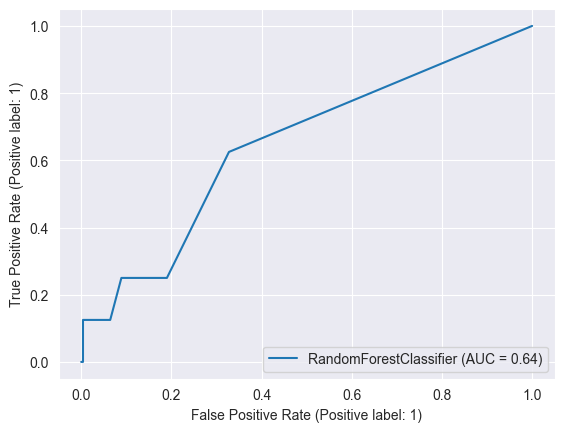

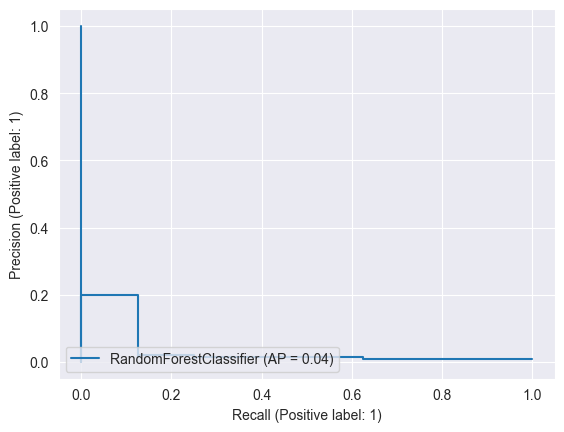

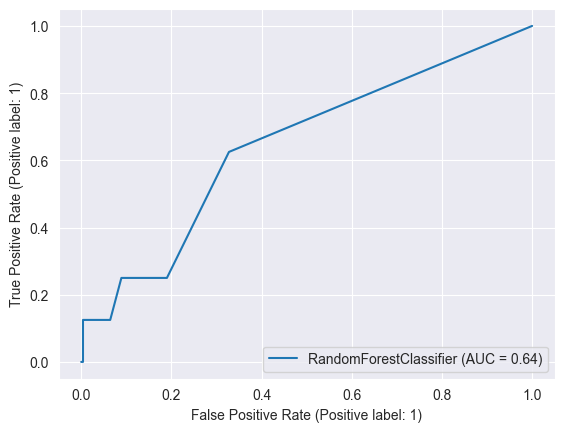

In [91]:
model_evaluation(rf_unscaled, X_valid, y_valid)

RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1043
           1       1.00      1.00      1.00       977

    accuracy                           1.00      2020
   macro avg       1.00      1.00      1.00      2020
weighted avg       1.00      1.00      1.00      2020

**************************************************


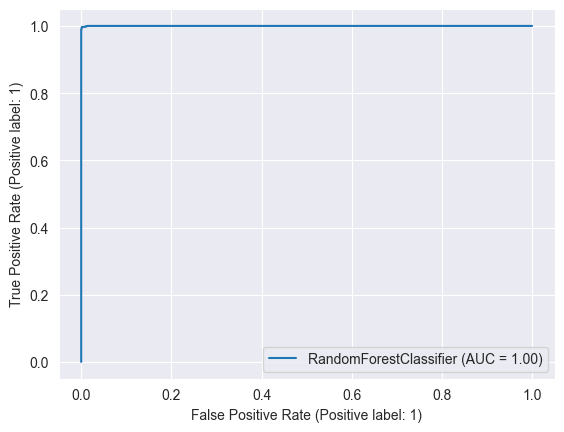

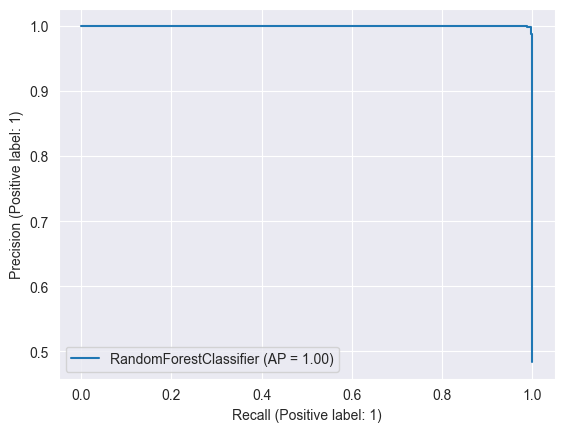

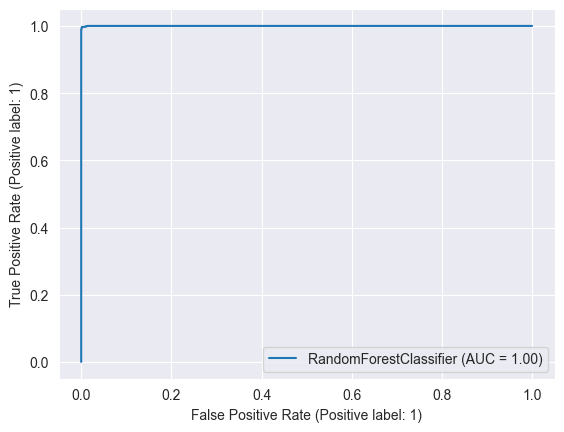

In [105]:
model_evaluation(rf_unscaled_smote, X_valid_oversampled, y_valid_oversampled)

On validation set clearly winner is RandomForest on oversampled data-set

It's worth to mention that we can do more experiments on scaling and normalizing dataset and trying different over/under sampling techniques, or trying different class weights, but for tight deadlines we will skip strong modeling part.

In [101]:
X_test, y_test = load_data("data", mode="test")

In [107]:
X_test = pca.fit_transform(X_test)

RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5050
           1       0.97      1.00      0.99        37

    accuracy                           1.00      5087
   macro avg       0.99      1.00      0.99      5087
weighted avg       1.00      1.00      1.00      5087

**************************************************


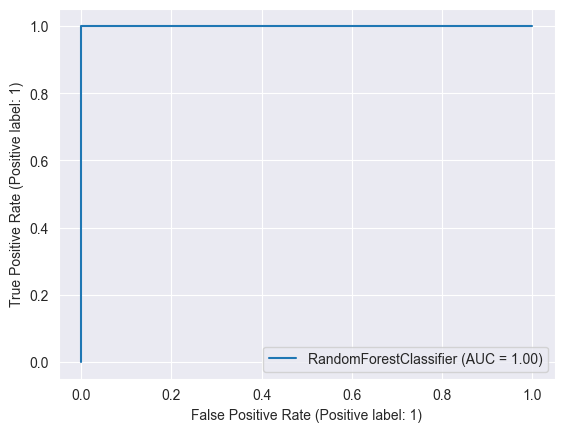

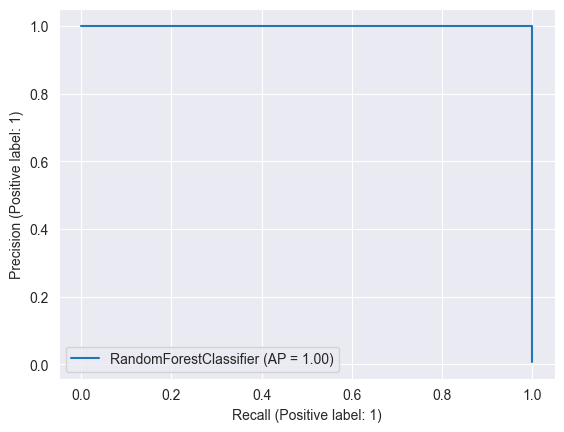

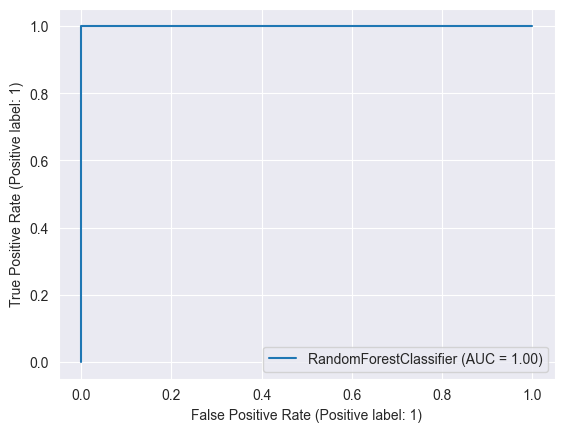

In [108]:
model_evaluation(rf_unscaled_smote, X_test, y_test)

Model performs very well on test set too.